In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-07-19 16:38:17.500263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [4]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [5]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [6]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (50, 180)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    num_parts = 7

    # Create a blank white image
    image = np.ones((*size, 1), dtype=np.uint8) * 255  # White background

    # Calculate positions for each part
    part_width = size[1] / num_parts
    vertical_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    vertical_positions = vertical_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_y = int((size[0] + cv2.getTextSize(text, font, font_scale, font_thickness)[0][1]) / 2)

    # Draw each letter at the calculated position
    for char, x in zip(text, vertical_positions):
        char_size, _ = cv2.getTextSize(char, font, font_scale, font_thickness)
        char_x = x - char_size[0] // 2  # Center the character horizontally within its part
        cv2.putText(image, char, (char_x, text_y), font, font_scale, (0,), font_thickness, lineType=cv2.LINE_AA)
    return image

In [7]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [8]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.
  return X,Y

X_train, Y_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

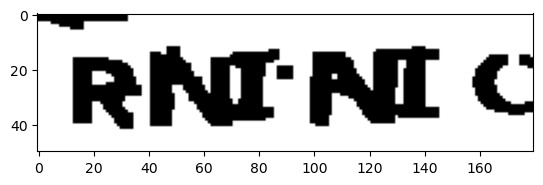

In [9]:
plt.imshow(X_train[0], cmap='gray')

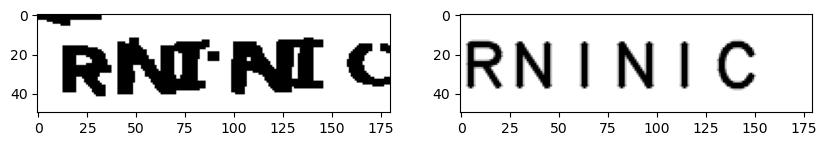

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [11]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)
batch_size = 64
augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

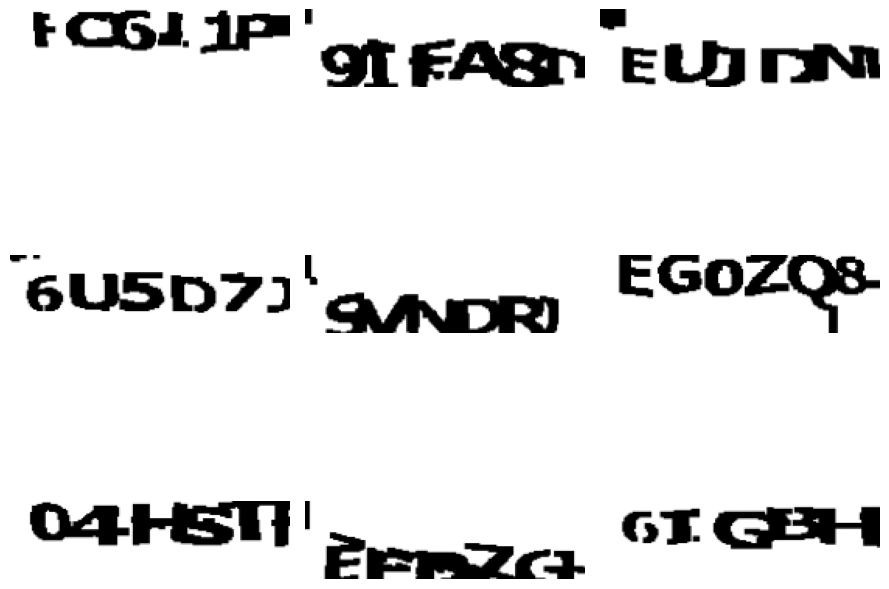

In [12]:
augmented_images, augmented_labels = next(augmented_data_generator)

# Display the first few augmented images and their corresponding labels
plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(50, 180), cmap='gray')  # Assuming images are grayscale
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [14]:
def conv_bn_relu(filters, kernel_size, strides=(1, 1), padding='same'):
    def layer(x):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x
    return layer

def crop(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return x2_cropped

In [15]:
def dae(input_img, num_blocks=1, num_downsample=3):
    x = input_img

    for _ in range(2):
        x = conv_bn_relu(64, (3, 3))(x)

    # Contracting path
    for _ in range(num_downsample):
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    
    shape_before_flattening = x.shape[1:]
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)

    x = Dense(np.prod(shape_before_flattening), activation='relu')(x)
    x = Reshape(shape_before_flattening)(x)

    # Expansive path
    for i in range(num_downsample - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
    
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)

    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    #crop for input_img shape
    output = crop(input_img,x)

    return tf.keras.Model(inputs=input_img, outputs=output)


input_shape = (50, 180, 1)  # Example input shape
input_img = Input(shape=input_shape)
autoencoder = dae(input_img, num_blocks=3, num_downsample=4)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rmse,psnr])
autoencoder.summary()

2024-07-19 16:38:22.761735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13747 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 180, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 50, 180, 64)       640       
                                                                 
 batch_normalization (Batch  (None, 50, 180, 64)       256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 50, 180, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 180, 64)       36928     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 180, 64)       256       
 chNormalization)                                            

In [16]:
checkpoint = ModelCheckpoint(
    'model_BCE_aug_best_3.tf',
    monitor='val_rmse',  # Use 'val_loss' as an approximation of RMSE if the metric isn't directly available
    save_best_only=True,
    mode='min',
    verbose=1
)

In [17]:
history = autoencoder.fit(augmented_data_generator,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=150,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/150


2024-07-19 16:38:30.485616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-07-19 16:38:31.859150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-19 16:38:32.579140: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x798804d082c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-19 16:38:32.579168: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-19 16:38:32.583315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-19 16:38:32.697820: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

125/125 [==============================] - ETA: 0s - loss: 0.2589 - rmse: 0.2579 - psnr: 11.9203
Epoch 1: val_rmse improved from inf to 0.31243, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 56s 280ms/step - loss: 0.2589 - rmse: 0.2579 - psnr: 11.9203 - val_loss: 0.3451 - val_rmse: 0.3124 - val_psnr: 10.1079
Epoch 2/150
125/125 [==============================] - ETA: 0s - loss: 0.2038 - rmse: 0.2345 - psnr: 12.6150
Epoch 2: val_rmse improved from 0.31243 to 0.23559, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 246ms/step - loss: 0.2038 - rmse: 0.2345 - psnr: 12.6150 - val_loss: 0.2052 - val_rmse: 0.2356 - val_psnr: 12.5756
Epoch 3/150
125/125 [==============================] - ETA: 0s - loss: 0.1987 - rmse: 0.2337 - psnr: 12.6464
Epoch 3: val_rmse improved from 0.23559 to 0.23359, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 251ms/step - loss: 0.1987 - rmse: 0.2337 - psnr: 12.6464 - val_loss: 0.1974 - val_rmse: 0.2336 - val_psnr: 12.6560
Epoch 4/150
125/125 [==============================] - ETA: 0s - loss: 0.1957 - rmse: 0.2322 - psnr: 12.7035
Epoch 4: val_rmse did not improve from 0.23359
125/125 [==============================] - 21s 171ms/step - loss: 0.1957 - rmse: 0.2322 - psnr: 12.7035 - val_loss: 0.2023 - val_rmse: 0.2372 - val_psnr: 12.5219
Epoch 5/150
125/125 [==============================] - ETA: 0s - loss: 0.1883 - rmse: 0.2261 - psnr: 12.9381
Epoch 5: val_rmse improved from 0.23359 to 0.22536, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 251ms/step - loss: 0.1883 - rmse: 0.2261 - psnr: 12.9381 - val_loss: 0.1870 - val_rmse: 0.2254 - val_psnr: 12.9573
Epoch 6/150
125/125 [==============================] - ETA: 0s - loss: 0.1757 - rmse: 0.2150 - psnr: 13.3919
Epoch 6: val_rmse did not improve from 0.22536
125/125 [==============================] - 22s 172ms/step - loss: 0.1757 - rmse: 0.2150 - psnr: 13.3919 - val_loss: 0.2440 - val_rmse: 0.2541 - val_psnr: 11.9453
Epoch 7/150
125/125 [==============================] - ETA: 0s - loss: 0.1653 - rmse: 0.2057 - psnr: 13.7872
Epoch 7: val_rmse did not improve from 0.22536
125/125 [==============================] - 21s 171ms/step - loss: 0.1653 - rmse: 0.2057 - psnr: 13.7872 - val_loss: 0.2590 - val_rmse: 0.2562 - val_psnr: 11.8711
Epoch 8/150
125/125 [==============================] - ETA: 0s - loss: 0.1568 - rmse: 0.1981 - psnr: 14.1240
Epoch 8: val_rmse did not improve from 0.22536
125/125 [==============================] - 21s

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 240ms/step - loss: 0.1452 - rmse: 0.1874 - psnr: 14.6266 - val_loss: 0.1740 - val_rmse: 0.2107 - val_psnr: 13.6243
Epoch 11/150
125/125 [==============================] - ETA: 0s - loss: 0.1425 - rmse: 0.1846 - psnr: 14.7638
Epoch 11: val_rmse did not improve from 0.21069
125/125 [==============================] - 22s 174ms/step - loss: 0.1425 - rmse: 0.1846 - psnr: 14.7638 - val_loss: 0.2228 - val_rmse: 0.2340 - val_psnr: 12.6667
Epoch 12/150
125/125 [==============================] - ETA: 0s - loss: 0.1400 - rmse: 0.1821 - psnr: 14.8823
Epoch 12: val_rmse did not improve from 0.21069
125/125 [==============================] - 30s 239ms/step - loss: 0.1400 - rmse: 0.1821 - psnr: 14.8823 - val_loss: 0.2247 - val_rmse: 0.2423 - val_psnr: 12.3864
Epoch 13/150
125/125 [==============================] - ETA: 0s - loss: 0.1366 - rmse: 0.1788 - psnr: 15.0522
Epoch 13: val_rmse improved from 0.21069 to 0.20762, saving model to model_BCE_aug_best_

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 248ms/step - loss: 0.1366 - rmse: 0.1788 - psnr: 15.0522 - val_loss: 0.1748 - val_rmse: 0.2076 - val_psnr: 13.7159
Epoch 14/150
125/125 [==============================] - ETA: 0s - loss: 0.1336 - rmse: 0.1758 - psnr: 15.2068
Epoch 14: val_rmse did not improve from 0.20762
125/125 [==============================] - 22s 176ms/step - loss: 0.1336 - rmse: 0.1758 - psnr: 15.2068 - val_loss: 0.1875 - val_rmse: 0.2159 - val_psnr: 13.3955
Epoch 15/150
125/125 [==============================] - ETA: 0s - loss: 0.1322 - rmse: 0.1744 - psnr: 15.2795
Epoch 15: val_rmse improved from 0.20762 to 0.20144, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 244ms/step - loss: 0.1322 - rmse: 0.1744 - psnr: 15.2795 - val_loss: 0.1718 - val_rmse: 0.2014 - val_psnr: 14.0351
Epoch 16/150
125/125 [==============================] - ETA: 0s - loss: 0.1297 - rmse: 0.1718 - psnr: 15.4161
Epoch 16: val_rmse improved from 0.20144 to 0.18903, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 239ms/step - loss: 0.1297 - rmse: 0.1718 - psnr: 15.4161 - val_loss: 0.1499 - val_rmse: 0.1890 - val_psnr: 14.5776
Epoch 17/150
125/125 [==============================] - ETA: 0s - loss: 0.1275 - rmse: 0.1696 - psnr: 15.5359
Epoch 17: val_rmse did not improve from 0.18903
125/125 [==============================] - 21s 171ms/step - loss: 0.1275 - rmse: 0.1696 - psnr: 15.5359 - val_loss: 0.1579 - val_rmse: 0.1989 - val_psnr: 14.0897
Epoch 18/150
125/125 [==============================] - ETA: 0s - loss: 0.1257 - rmse: 0.1676 - psnr: 15.6490
Epoch 18: val_rmse improved from 0.18903 to 0.16961, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 240ms/step - loss: 0.1257 - rmse: 0.1676 - psnr: 15.6490 - val_loss: 0.1276 - val_rmse: 0.1696 - val_psnr: 15.5186
Epoch 19/150
125/125 [==============================] - ETA: 0s - loss: 0.1249 - rmse: 0.1669 - psnr: 15.6870
Epoch 19: val_rmse did not improve from 0.16961
125/125 [==============================] - 21s 170ms/step - loss: 0.1249 - rmse: 0.1669 - psnr: 15.6870 - val_loss: 0.1787 - val_rmse: 0.2128 - val_psnr: 13.5004
Epoch 20/150
125/125 [==============================] - ETA: 0s - loss: 0.1218 - rmse: 0.1636 - psnr: 15.8676
Epoch 20: val_rmse did not improve from 0.16961
125/125 [==============================] - 21s 168ms/step - loss: 0.1218 - rmse: 0.1636 - psnr: 15.8676 - val_loss: 0.1659 - val_rmse: 0.1980 - val_psnr: 14.2055
Epoch 21/150
125/125 [==============================] - ETA: 0s - loss: 0.1218 - rmse: 0.1636 - psnr: 15.8740
Epoch 21: val_rmse did not improve from 0.16961
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 237ms/step - loss: 0.1172 - rmse: 0.1588 - psnr: 16.1454 - val_loss: 0.1237 - val_rmse: 0.1659 - val_psnr: 15.7561
Epoch 25/150
125/125 [==============================] - ETA: 0s - loss: 0.1166 - rmse: 0.1582 - psnr: 16.1886
Epoch 25: val_rmse did not improve from 0.16589
125/125 [==============================] - 21s 170ms/step - loss: 0.1166 - rmse: 0.1582 - psnr: 16.1886 - val_loss: 0.1267 - val_rmse: 0.1684 - val_psnr: 15.6431
Epoch 26/150
125/125 [==============================] - ETA: 0s - loss: 0.1163 - rmse: 0.1578 - psnr: 16.2116
Epoch 26: val_rmse did not improve from 0.16589
125/125 [==============================] - 21s 170ms/step - loss: 0.1163 - rmse: 0.1578 - psnr: 16.2116 - val_loss: 0.1577 - val_rmse: 0.1910 - val_psnr: 14.5681
Epoch 27/150
125/125 [==============================] - ETA: 0s - loss: 0.1156 - rmse: 0.1571 - psnr: 16.2615
Epoch 27: val_rmse did not improve from 0.16589
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.1031 - rmse: 0.1432 - psnr: 17.1328 - val_loss: 0.1113 - val_rmse: 0.1546 - val_psnr: 16.4789
Epoch 40/150
125/125 [==============================] - ETA: 0s - loss: 0.1028 - rmse: 0.1428 - psnr: 17.1692
Epoch 40: val_rmse did not improve from 0.15459
125/125 [==============================] - 22s 176ms/step - loss: 0.1028 - rmse: 0.1428 - psnr: 17.1692 - val_loss: 0.1382 - val_rmse: 0.1773 - val_psnr: 15.2786
Epoch 41/150
125/125 [==============================] - ETA: 0s - loss: 0.1021 - rmse: 0.1421 - psnr: 17.2176
Epoch 41: val_rmse did not improve from 0.15459
125/125 [==============================] - 22s 176ms/step - loss: 0.1021 - rmse: 0.1421 - psnr: 17.2176 - val_loss: 0.1263 - val_rmse: 0.1687 - val_psnr: 15.6911
Epoch 42/150
125/125 [==============================] - ETA: 0s - loss: 0.0996 - rmse: 0.1391 - psnr: 17.4039
Epoch 42: val_rmse did not improve from 0.15459
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 245ms/step - loss: 0.0993 - rmse: 0.1387 - psnr: 17.4272 - val_loss: 0.1110 - val_rmse: 0.1520 - val_psnr: 16.5946
Epoch 44/150
125/125 [==============================] - ETA: 0s - loss: 0.0998 - rmse: 0.1394 - psnr: 17.3857
Epoch 44: val_rmse improved from 0.15200 to 0.14647, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 32s 254ms/step - loss: 0.0998 - rmse: 0.1394 - psnr: 17.3857 - val_loss: 0.1048 - val_rmse: 0.1465 - val_psnr: 17.0103
Epoch 45/150
125/125 [==============================] - ETA: 0s - loss: 0.0966 - rmse: 0.1353 - psnr: 17.6865
Epoch 45: val_rmse did not improve from 0.14647
125/125 [==============================] - 22s 177ms/step - loss: 0.0966 - rmse: 0.1353 - psnr: 17.6865 - val_loss: 0.1069 - val_rmse: 0.1476 - val_psnr: 16.8904
Epoch 46/150
125/125 [==============================] - ETA: 0s - loss: 0.0962 - rmse: 0.1348 - psnr: 17.7189
Epoch 46: val_rmse did not improve from 0.14647
125/125 [==============================] - 22s 176ms/step - loss: 0.0962 - rmse: 0.1348 - psnr: 17.7189 - val_loss: 0.1357 - val_rmse: 0.1753 - val_psnr: 15.4124
Epoch 47/150
125/125 [==============================] - ETA: 0s - loss: 0.0967 - rmse: 0.1356 - psnr: 17.6526
Epoch 47: val_rmse did not improve from 0.14647
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 249ms/step - loss: 0.0936 - rmse: 0.1313 - psnr: 18.0020 - val_loss: 0.0935 - val_rmse: 0.1323 - val_psnr: 17.9554
Epoch 53/150
125/125 [==============================] - ETA: 0s - loss: 0.0924 - rmse: 0.1299 - psnr: 18.0888
Epoch 53: val_rmse did not improve from 0.13229
125/125 [==============================] - 22s 177ms/step - loss: 0.0924 - rmse: 0.1299 - psnr: 18.0888 - val_loss: 0.1080 - val_rmse: 0.1480 - val_psnr: 16.9319
Epoch 54/150
125/125 [==============================] - ETA: 0s - loss: 0.0911 - rmse: 0.1281 - psnr: 18.2295
Epoch 54: val_rmse did not improve from 0.13229
125/125 [==============================] - 22s 177ms/step - loss: 0.0911 - rmse: 0.1281 - psnr: 18.2295 - val_loss: 0.1206 - val_rmse: 0.1620 - val_psnr: 16.0994
Epoch 55/150
125/125 [==============================] - ETA: 0s - loss: 0.0920 - rmse: 0.1293 - psnr: 18.1404
Epoch 55: val_rmse did not improve from 0.13229
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 241ms/step - loss: 0.0843 - rmse: 0.1185 - psnr: 19.0130 - val_loss: 0.0947 - val_rmse: 0.1316 - val_psnr: 17.9915
Epoch 63/150
125/125 [==============================] - ETA: 0s - loss: 0.0848 - rmse: 0.1189 - psnr: 19.0145
Epoch 63: val_rmse did not improve from 0.13162
125/125 [==============================] - 22s 177ms/step - loss: 0.0848 - rmse: 0.1189 - psnr: 19.0145 - val_loss: 0.0975 - val_rmse: 0.1380 - val_psnr: 17.5110
Epoch 64/150
125/125 [==============================] - ETA: 0s - loss: 0.0840 - rmse: 0.1182 - psnr: 19.0286
Epoch 64: val_rmse did not improve from 0.13162
125/125 [==============================] - 22s 176ms/step - loss: 0.0840 - rmse: 0.1182 - psnr: 19.0286 - val_loss: 0.1253 - val_rmse: 0.1637 - val_psnr: 16.0710
Epoch 65/150
125/125 [==============================] - ETA: 0s - loss: 0.0833 - rmse: 0.1168 - psnr: 19.2057
Epoch 65: val_rmse improved from 0.13162 to 0.12874, saving model to model_BCE_aug_best_

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 250ms/step - loss: 0.0833 - rmse: 0.1168 - psnr: 19.2057 - val_loss: 0.0910 - val_rmse: 0.1287 - val_psnr: 18.2533
Epoch 66/150
125/125 [==============================] - ETA: 0s - loss: 0.0830 - rmse: 0.1167 - psnr: 19.1825
Epoch 66: val_rmse did not improve from 0.12874
125/125 [==============================] - 22s 176ms/step - loss: 0.0830 - rmse: 0.1167 - psnr: 19.1825 - val_loss: 0.1013 - val_rmse: 0.1391 - val_psnr: 17.6135
Epoch 67/150
125/125 [==============================] - ETA: 0s - loss: 0.0933 - rmse: 0.1299 - psnr: 18.2464
Epoch 67: val_rmse improved from 0.12874 to 0.11655, saving model to model_BCE_aug_best_3.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 247ms/step - loss: 0.0933 - rmse: 0.1299 - psnr: 18.2464 - val_loss: 0.0828 - val_rmse: 0.1165 - val_psnr: 19.0799
Epoch 68/150
125/125 [==============================] - ETA: 0s - loss: 0.0895 - rmse: 0.1259 - psnr: 18.4635
Epoch 68: val_rmse did not improve from 0.11655
125/125 [==============================] - 22s 177ms/step - loss: 0.0895 - rmse: 0.1259 - psnr: 18.4635 - val_loss: 0.1053 - val_rmse: 0.1406 - val_psnr: 17.6528
Epoch 69/150
125/125 [==============================] - ETA: 0s - loss: 0.0836 - rmse: 0.1177 - psnr: 19.1225
Epoch 69: val_rmse did not improve from 0.11655
125/125 [==============================] - 22s 177ms/step - loss: 0.0836 - rmse: 0.1177 - psnr: 19.1225 - val_loss: 0.0915 - val_rmse: 0.1292 - val_psnr: 18.1339
Epoch 70/150
125/125 [==============================] - ETA: 0s - loss: 0.0844 - rmse: 0.1190 - psnr: 18.9999
Epoch 70: val_rmse did not improve from 0.11655
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 241ms/step - loss: 0.0794 - rmse: 0.1115 - psnr: 19.6945 - val_loss: 0.0756 - val_rmse: 0.1059 - val_psnr: 19.9941
Epoch 76/150
125/125 [==============================] - ETA: 0s - loss: 0.0798 - rmse: 0.1118 - psnr: 19.6928
Epoch 76: val_rmse did not improve from 0.10588
125/125 [==============================] - 22s 177ms/step - loss: 0.0798 - rmse: 0.1118 - psnr: 19.6928 - val_loss: 0.1027 - val_rmse: 0.1374 - val_psnr: 17.8472
Epoch 77/150
125/125 [==============================] - ETA: 0s - loss: 0.0794 - rmse: 0.1113 - psnr: 19.7447
Epoch 77: val_rmse did not improve from 0.10588
125/125 [==============================] - 22s 177ms/step - loss: 0.0794 - rmse: 0.1113 - psnr: 19.7447 - val_loss: 0.0941 - val_rmse: 0.1317 - val_psnr: 18.1416
Epoch 78/150
125/125 [==============================] - ETA: 0s - loss: 0.0794 - rmse: 0.1113 - psnr: 19.7554
Epoch 78: val_rmse did not improve from 0.10588
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 241ms/step - loss: 0.0752 - rmse: 0.1050 - psnr: 20.3771 - val_loss: 0.0682 - val_rmse: 0.0946 - val_psnr: 21.2042
Epoch 84/150
125/125 [==============================] - ETA: 0s - loss: 0.0752 - rmse: 0.1051 - psnr: 20.3695
Epoch 84: val_rmse did not improve from 0.09458
125/125 [==============================] - 22s 178ms/step - loss: 0.0752 - rmse: 0.1051 - psnr: 20.3695 - val_loss: 0.1065 - val_rmse: 0.1477 - val_psnr: 17.0679
Epoch 85/150
125/125 [==============================] - ETA: 0s - loss: 0.0764 - rmse: 0.1069 - psnr: 20.2067
Epoch 85: val_rmse did not improve from 0.09458
125/125 [==============================] - 22s 177ms/step - loss: 0.0764 - rmse: 0.1069 - psnr: 20.2067 - val_loss: 0.0869 - val_rmse: 0.1234 - val_psnr: 18.5753
Epoch 86/150
125/125 [==============================] - ETA: 0s - loss: 0.0749 - rmse: 0.1045 - psnr: 20.4705
Epoch 86: val_rmse did not improve from 0.09458
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 30s 243ms/step - loss: 0.0724 - rmse: 0.1006 - psnr: 20.8841 - val_loss: 0.0672 - val_rmse: 0.0929 - val_psnr: 21.3434
Epoch 90/150
125/125 [==============================] - ETA: 0s - loss: 0.0734 - rmse: 0.1021 - psnr: 20.7265
Epoch 90: val_rmse did not improve from 0.09292
125/125 [==============================] - 22s 177ms/step - loss: 0.0734 - rmse: 0.1021 - psnr: 20.7265 - val_loss: 0.0926 - val_rmse: 0.1288 - val_psnr: 18.3447
Epoch 91/150
125/125 [==============================] - ETA: 0s - loss: 0.0739 - rmse: 0.1031 - psnr: 20.6106
Epoch 91: val_rmse did not improve from 0.09292
125/125 [==============================] - 22s 176ms/step - loss: 0.0739 - rmse: 0.1031 - psnr: 20.6106 - val_loss: 0.1175 - val_rmse: 0.1494 - val_psnr: 17.1467
Epoch 92/150
125/125 [==============================] - ETA: 0s - loss: 0.0740 - rmse: 0.1028 - psnr: 20.6552
Epoch 92: val_rmse improved from 0.09292 to 0.09292, saving model to model_BCE_aug_best_

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 245ms/step - loss: 0.0740 - rmse: 0.1028 - psnr: 20.6552 - val_loss: 0.0676 - val_rmse: 0.0929 - val_psnr: 21.5198
Epoch 93/150
125/125 [==============================] - ETA: 0s - loss: 0.0703 - rmse: 0.0975 - psnr: 21.1936
Epoch 93: val_rmse did not improve from 0.09292
125/125 [==============================] - 22s 178ms/step - loss: 0.0703 - rmse: 0.0975 - psnr: 21.1936 - val_loss: 0.0742 - val_rmse: 0.1048 - val_psnr: 20.3472
Epoch 94/150
125/125 [==============================] - ETA: 0s - loss: 0.0713 - rmse: 0.0991 - psnr: 21.0476
Epoch 94: val_rmse did not improve from 0.09292
125/125 [==============================] - 22s 175ms/step - loss: 0.0713 - rmse: 0.0991 - psnr: 21.0476 - val_loss: 0.0865 - val_rmse: 0.1221 - val_psnr: 18.9128
Epoch 95/150
125/125 [==============================] - ETA: 0s - loss: 0.0730 - rmse: 0.1015 - psnr: 20.8125
Epoch 95: val_rmse did not improve from 0.09292
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 29s 234ms/step - loss: 0.0684 - rmse: 0.0943 - psnr: 21.5944 - val_loss: 0.0622 - val_rmse: 0.0834 - val_psnr: 22.6909
Epoch 101/150
125/125 [==============================] - ETA: 0s - loss: 0.0681 - rmse: 0.0938 - psnr: 21.6848
Epoch 101: val_rmse did not improve from 0.08339
125/125 [==============================] - 21s 171ms/step - loss: 0.0681 - rmse: 0.0938 - psnr: 21.6848 - val_loss: 0.0654 - val_rmse: 0.0894 - val_psnr: 22.0319
Epoch 102/150
125/125 [==============================] - ETA: 0s - loss: 0.0705 - rmse: 0.0977 - psnr: 21.2687
Epoch 102: val_rmse did not improve from 0.08339
125/125 [==============================] - 21s 171ms/step - loss: 0.0705 - rmse: 0.0977 - psnr: 21.2687 - val_loss: 0.0701 - val_rmse: 0.0982 - val_psnr: 20.9249
Epoch 103/150
125/125 [==============================] - ETA: 0s - loss: 0.0683 - rmse: 0.0943 - psnr: 21.5868
Epoch 103: val_rmse did not improve from 0.08339
125/125 [=========================

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 31s 248ms/step - loss: 0.0650 - rmse: 0.0886 - psnr: 22.3775 - val_loss: 0.0590 - val_rmse: 0.0771 - val_psnr: 23.4498
Epoch 111/150
125/125 [==============================] - ETA: 0s - loss: 0.0664 - rmse: 0.0911 - psnr: 22.0380
Epoch 111: val_rmse did not improve from 0.07713
125/125 [==============================] - 22s 174ms/step - loss: 0.0664 - rmse: 0.0911 - psnr: 22.0380 - val_loss: 0.0683 - val_rmse: 0.0943 - val_psnr: 21.5308
Epoch 112/150
125/125 [==============================] - ETA: 0s - loss: 0.0677 - rmse: 0.0933 - psnr: 21.7268
Epoch 112: val_rmse did not improve from 0.07713
125/125 [==============================] - 29s 231ms/step - loss: 0.0677 - rmse: 0.0933 - psnr: 21.7268 - val_loss: 0.0904 - val_rmse: 0.1266 - val_psnr: 18.5771
Epoch 113/150
125/125 [==============================] - ETA: 0s - loss: 0.0654 - rmse: 0.0896 - psnr: 22.2897
Epoch 113: val_rmse did not improve from 0.07713
125/125 [=========================

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 36s 289ms/step - loss: 0.0624 - rmse: 0.0840 - psnr: 23.0517 - val_loss: 0.0571 - val_rmse: 0.0738 - val_psnr: 24.1407
Epoch 128/150
125/125 [==============================] - ETA: 0s - loss: 0.0647 - rmse: 0.0880 - psnr: 22.5372
Epoch 128: val_rmse did not improve from 0.07376
125/125 [==============================] - 24s 192ms/step - loss: 0.0647 - rmse: 0.0880 - psnr: 22.5372 - val_loss: 0.0643 - val_rmse: 0.0879 - val_psnr: 22.0545
Epoch 129/150
125/125 [==============================] - ETA: 0s - loss: 0.0624 - rmse: 0.0840 - psnr: 23.0982
Epoch 129: val_rmse did not improve from 0.07376
125/125 [==============================] - 22s 172ms/step - loss: 0.0624 - rmse: 0.0840 - psnr: 23.0982 - val_loss: 0.0699 - val_rmse: 0.0973 - val_psnr: 21.3672
Epoch 130/150
125/125 [==============================] - ETA: 0s - loss: 0.0637 - rmse: 0.0863 - psnr: 22.7734
Epoch 130: val_rmse did not improve from 0.07376
125/125 [=========================

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 34s 271ms/step - loss: 0.0612 - rmse: 0.0818 - psnr: 23.4614 - val_loss: 0.0549 - val_rmse: 0.0678 - val_psnr: 25.3636
Epoch 135/150
125/125 [==============================] - ETA: 0s - loss: 0.0599 - rmse: 0.0790 - psnr: 24.0288
Epoch 135: val_rmse did not improve from 0.06779
125/125 [==============================] - 21s 169ms/step - loss: 0.0599 - rmse: 0.0790 - psnr: 24.0288 - val_loss: 0.0588 - val_rmse: 0.0769 - val_psnr: 23.7766
Epoch 136/150
125/125 [==============================] - ETA: 0s - loss: 0.0612 - rmse: 0.0817 - psnr: 23.4866
Epoch 136: val_rmse did not improve from 0.06779
125/125 [==============================] - 21s 171ms/step - loss: 0.0612 - rmse: 0.0817 - psnr: 23.4866 - val_loss: 0.0587 - val_rmse: 0.0767 - val_psnr: 23.7931
Epoch 137/150
125/125 [==============================] - ETA: 0s - loss: 0.0614 - rmse: 0.0822 - psnr: 23.4617
Epoch 137: val_rmse did not improve from 0.06779
125/125 [=========================

INFO:tensorflow:Assets written to: model_BCE_aug_best_3.tf/assets


125/125 [==============================] - 32s 258ms/step - loss: 0.0579 - rmse: 0.0748 - psnr: 24.7931 - val_loss: 0.0543 - val_rmse: 0.0669 - val_psnr: 25.3751
Epoch 150/150
125/125 [==============================] - ETA: 0s - loss: 0.0583 - rmse: 0.0754 - psnr: 24.8092
Epoch 150: val_rmse did not improve from 0.06694
125/125 [==============================] - 22s 177ms/step - loss: 0.0583 - rmse: 0.0754 - psnr: 24.8092 - val_loss: 0.0659 - val_rmse: 0.0892 - val_psnr: 22.4233


In [18]:
Y_train_pred = autoencoder.predict(X_train)
Y_val_pred = autoencoder.predict(X_val)

32/32 [==============================] - 2s 40ms/step


In [19]:
def display_images(images, Y, Y_pred, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 6))
    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[idx].reshape(50,180), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Ground truth labels (Y)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(Y[idx].reshape(50, 180), cmap="gray")
        plt.title("Y")
        plt.axis("off")

        # Reconstructed images (Y_pred)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(Y_pred[idx].reshape(50, 180), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

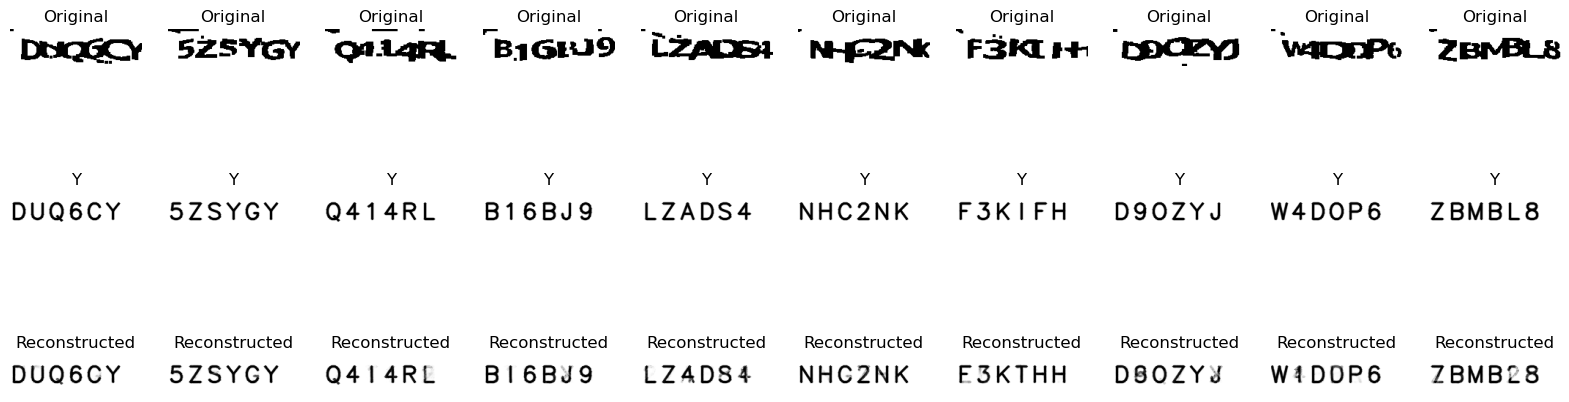

In [20]:
display_images(X_train, Y_train, Y_train_pred, num_images=10)

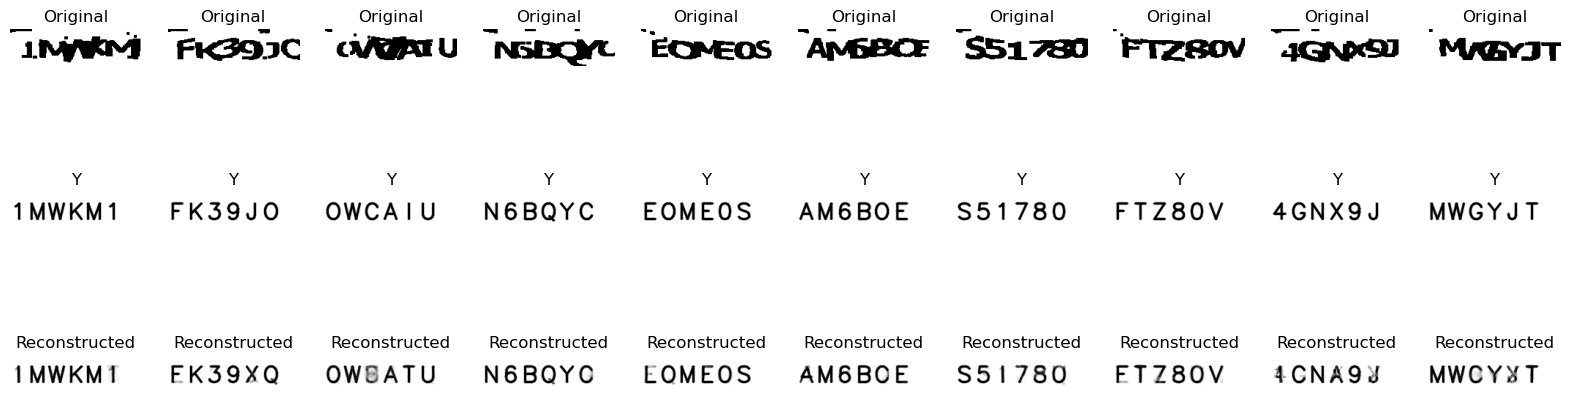

In [21]:
display_images(X_val, Y_val, Y_val_pred, num_images=10)

In [22]:
autoencoder.save('model_BCE_aug_150_2.keras')